<a href="https://colab.research.google.com/github/Naga-SDonepudi/PyTorch_HandsOn/blob/main/7_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
* Leveraging a pre-trained model (with learned parameters on a dataset) to use it on another dataset (with some tuning).

In [1]:
import torch
import torchvision

In [2]:
!pip install -q torchinfo

In [3]:
from torch import nn
from torchvision import transforms
from torchinfo import summary

# Importing modular scripts from github
!git clone https://github.com/Naga-SDonepudi/PyTorch_HandsOn.git
!mv PyTorch_HandsOn/modular_scripts .
!rm -rf PyTorch_HandsOn
from modular_scripts import data_setup_script, engine_script


Cloning into 'PyTorch_HandsOn'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 165 (delta 48), reused 51 (delta 38), pack-reused 101 (from 1)
Receiving objects: 100% (165/165), 29.17 MiB | 17.80 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [4]:
data_setup_script

<module 'modular_scripts.data_setup_script' from '/content/modular_scripts/data_setup_script.py'>

In [5]:
## Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Data

In [53]:
import os
import zipfile
from pathlib import Path
import requests

# Data Path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/Naga-SDonepudi/PyTorch_HandsOn/raw/refs/heads/main/DataSets%20&%20Images/pizza_steak_sushi.zip")
  print("Downlaoded pizaa, steak and sushi data from GitHub repository")
  f.write(request.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

  os.remove(data_path / "pizza_steak_sushi.zip")

Downlaoded pizaa, steak and sushi data from GitHub repository


In [54]:
## Doreactory paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2. Datasets and Dataloaders


In [55]:
from modular_scripts import data_setup_script

In [56]:
## creating a transform (using auto creation)
from torchvision import models

In [57]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

### 2.1 Using auto-create to have a preprocessing line, to make our custom data is transformed in same way as the pretrained model

In [58]:
## Getting pretrained model weights (DEFAULT is equivalent to IMAGENET1K where the model was trained on)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [59]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [60]:
## Datalodaers
train_dataloader, test_dataloader, class_names = data_setup_script.create_dataloaders(train_dir = train_dir,
                                                                                      test_dir = test_dir,
                                                                                      transform = auto_transforms,
                                                                                      batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a4070116ab0>,
 ['pizza', 'steak', 'sushi'])

## 3. Loading a pretrained model


Things to consider during transfer learning ie while using a pretrained model
* speed, size and performance: how fast the model run, how big is it, and how good does it run on current data
* So chhosing a EffNetB0

In [61]:
## Creating a pretrained model and instantinating
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [62]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.1 Summary of the model

In [63]:
summary(model=model,
        input_size=(1, 3, 224, 224), ## (batchize, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

* Here, all the layers are trainable but inorder to get the output shape to be equal to output class of our custom dataset, the layers should be freezed (ie trainable=False) except for the output classifier layer.
* Altering the trainable parameters of only classifier section.

### 3.3 Base model freezing and changing the output layer
* A feature extraction can be done on pretarined model with freezing the baseline model (using the same learned patterns and weights)
* Updating only the output layer (classifier)

In [64]:
for param in model.features.parameters():
  param.requires_grad = False   #To stop PyTorch from keep tracking gradients of params and it will lead to no update of params during the optimization step


In [65]:
summary(model=model,
        input_size=(1, 3, 224, 224), ## (batchize, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

* Here, it clearly shows that all the feature layers were freezed.
* Count of tarinable params changed (from 5.2M to 1.28M)
* Only the output classfier layer params can be updated

In [66]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [67]:
## Updating the classifier layer to make it suit the current problem\
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names)) # Make suring it suits the number of classes on our custom data set ie 3
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [68]:
summary(model=model,
        input_size=(1, 3, 224, 224), ## (batchize, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 4. Training the model

In [69]:
# Loss funcxtion and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [70]:
## Importing the engine_script.py files as it has train function
from modular_scripts import engine_script

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# setting the timer
from timeit import default_timer as timer
start_time = timer()

results = engine_script.train(model=model,
                              train_dataloader = train_dataloader,
                              test_dataloader = test_dataloader,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 6,
                              device = device)

end_time = timer()
print(f"Total time took for training: {end_time - start_time: .2f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 1.0924 | Training Accuracy: 0.40% | Test Loss: 0.9133 | Test Accuracy: 0.54%
Epoch: 1 | Training Loss: 0.8717 | Training Accuracy: 0.78% | Test Loss: 0.7912 | Test Accuracy: 0.82%
Epoch: 2 | Training Loss: 0.7648 | Training Accuracy: 0.79% | Test Loss: 0.7463 | Test Accuracy: 0.86%
Epoch: 3 | Training Loss: 0.7109 | Training Accuracy: 0.75% | Test Loss: 0.6373 | Test Accuracy: 0.87%
Epoch: 4 | Training Loss: 0.6255 | Training Accuracy: 0.79% | Test Loss: 0.6261 | Test Accuracy: 0.86%
Epoch: 5 | Training Loss: 0.5785 | Training Accuracy: 0.89% | Test Loss: 0.5743 | Test Accuracy: 0.88%
Total time took for training:  12.93 seconds


### 5. Plotting the loss curve
* Importing a helper functions which has different functions defined

In [73]:
### 5. Helper function from github
with open("helper_functions.py", "wb") as f:
  import requests
  request = requests.get("https://raw.githubusercontent.com/Naga-SDonepudi/PyTorch_HandsOn/refs/heads/main/DataSets%20%26%20Images/helper_functions.py")
  f.write(request.content)
from helper_functions import plot_loss_curves

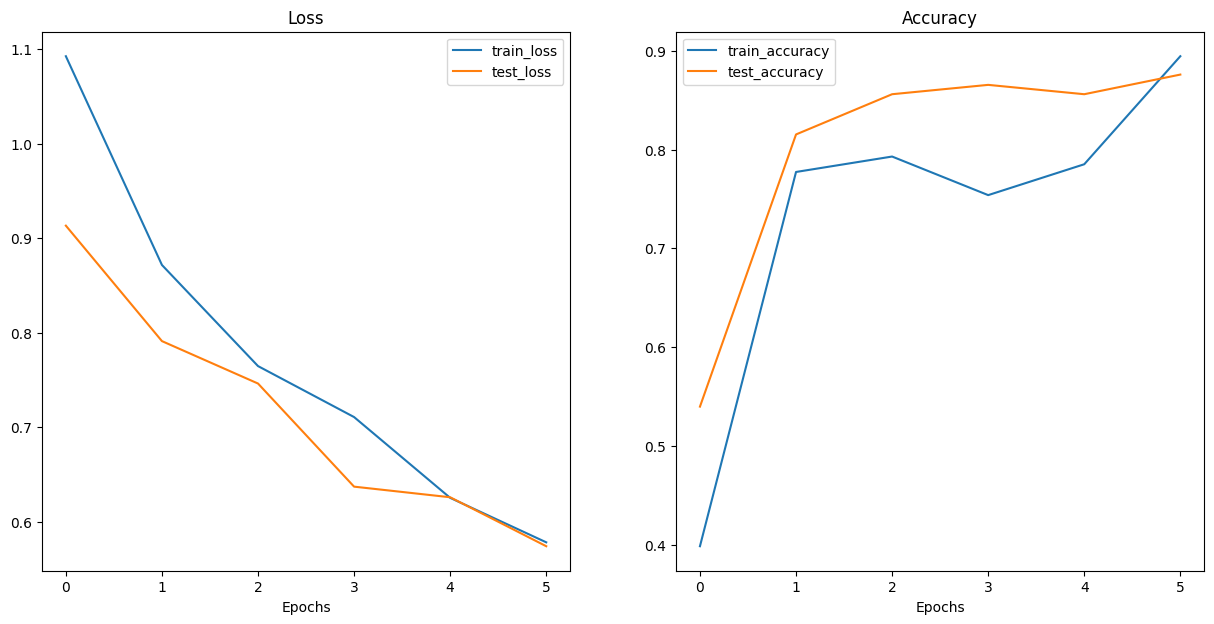

In [74]:
plot_loss_curves(results)

### 6. Predictions on a random test image
* Custom dataset image from test should be of same shape of pretrained model (ie transfered)
* datatype should be same and data should be stored in same device as model

In [92]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

## Taking a trained model
def pred_plot_img(model: torch.nn.Module,
                  image_path: str,
                  class_names: List[str],
                  image_size: Tuple[int, int] = (224, 224),
                  transform: torchvision.transforms = None,
                  device: torch.device=device):

  ## Opening the image with PIL library
  image = Image.open(image_path)

  ## Transform
  image_transform = transforms.Compose([transforms.Resize(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

  ## Device
  model.to(device)

  ## Eval mode
  model.eval()
  with torch.inference_mode():

    ## Tranforming the image (need to add a batch dimension as we are working only with 1 image)
    transformed_image = image_transform(image).unsqueeze(dim=0)

    ## Making predictions on transform image
    target_img_pred = model(transformed_image.to(device))

  ## Output logits to prediction probabiltities (output will be logits after prediction)
  target_img_pred_prob = torch.softmax(target_img_pred, dim=1)

  ## Pred prob to pred labels
  target_img_pred_lab = torch.argmax(target_img_pred_prob, dim=1)

  ## Plot
  plt.figure()
  plt.imshow(image)
  plt.title(f"Prediction Label: {class_names[target_img_pred_lab]} | Prediction Probability: {target_img_pred_prob.max():.2f}")
  plt.axis(False)

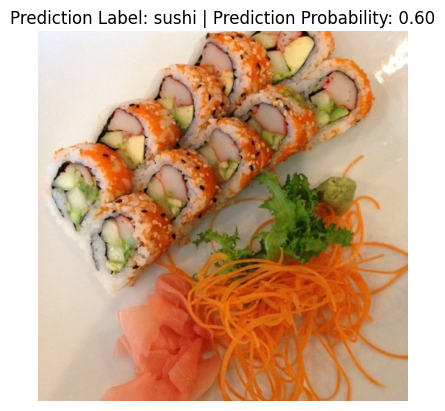

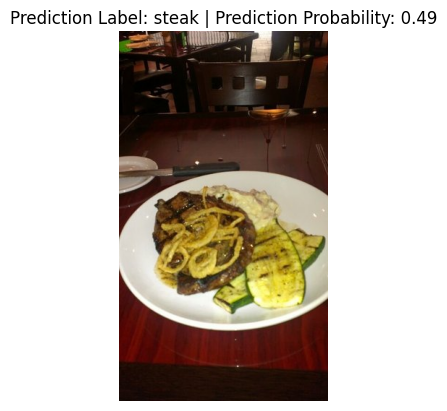

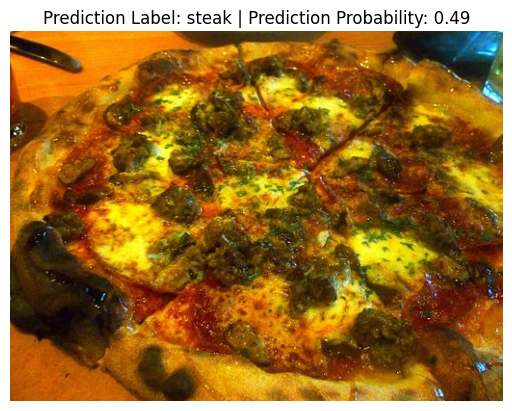

In [97]:
# Randomly selecting a list of image paths
import random
images_to_plot = 3

test_images_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_samples = random.sample(population=test_images_path_list,
                                   k=images_to_plot)

# Time for predictions on these randomly selected images
for img_path in test_image_samples:
  pred_plot_img(model=model,
                image_path=img_path,
                class_names=class_names,
                image_size=(224,224))

## Importing a custom image to make prediction on that image

In [103]:
import requests

custom_img_path = data_path / "pizz.jpg.jpg"
with open(custom_img_path, "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/Naga-SDonepudi/PyTorch_HandsOn/refs/heads/main/DataSets%20%26%20Images/pizz.jpg.jpg")
  f.write(request.content)
  print(f"Downaloaded the image")

Downaloaded the image


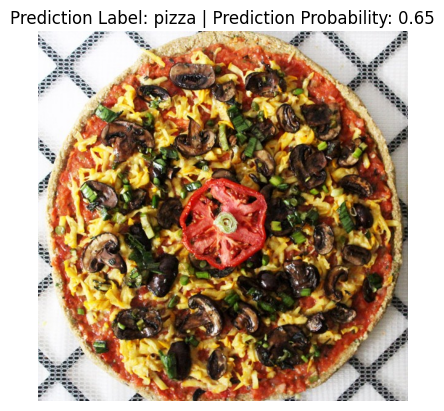

In [104]:
pred_plot_img(model=model,
              image_path=custom_img_path,
              class_names=class_names)